In [13]:
!pip install -U -q scikit-image imagecodecs scipy matplotlib numpy

In [3]:
### Image processing functions
from skimage import io as skio ## Image input/output
from skimage import morphology as skm ## Mask processing
from skimage.color import label2rgb ## For plotting: render each mask with its own color
from skimage.feature import peak_local_max ## For watershed: find maxima of distance to use watershed algorithm and try mask separation
from skimage.measure import label ## Assign to every object a unique ID based on pixel connectivity
from skimage.segmentation import watershed ## Apply watershed algorithm
from scipy.ndimage import binary_fill_holes, binary_erosion, distance_transform_edt ## Run a first-pass processing of the masks, compute the euclidean distance of every pixel to the background (neccesary for peak_local_max)

from matplotlib import pyplot as plt

import numpy as np
import imagecodecs
from glob import glob

import warnings
warnings.filterwarnings('ignore')

The output of Ilastik segmentations are images were each feature (in our case, background and plaques) has a unique value that's greater than 0 (1 for background, 2 for plaques). THis value must be specified to obtain the necessary binary images to then obtain instances through the watershed.

Our watershed segmentation is based on the [scikit-image documentation](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_watershed.html), so we recommend following this link also for a detailed explanation on how the algorithm works

In [2]:
### Define a function for easy segmentation of images based on their path

def WatershedSegmentation(segmentation_path:str, segmentation_value=2):

    ## Read the segmentation image and convert to a binary
    segmentation = imagecodecs.imread(segmentation_path) == segmentation_value

    ## Run a first-pass processing of the masks, 
    processed_segmentation = binary_fill_holes(binary_erosion(segmentation))

    ## Compute the euclidean distance of every pixel to the background 
    distance = distance_transform_edt(processed_segmentation)

    ## Otain local maxima 
    local_max_coords = peak_local_max(distance, min_distance=7)
    local_max_mask = np.zeros(distance.shape, dtype=bool)
    local_max_mask[tuple(local_max_coords.T)] = True
    markers = label(local_max_mask)

    ## Generate instances
    segmented_cells = skm.erosion(watershed(-distance, markers, mask=processed_segmentation))

    return segmented_cells

In [25]:
## Download example images and masks if needed, then move to a new directory

!wget https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/large_plaque_example.tif
!wget https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/large_plaque_example_segmentation.tif
!wget https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/small_plaque_example.tif
!wget https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/small_plaque_example_segmentation.tif

--2025-08-27 13:46:51--  https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/large_plaque_example.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘large_plaque_example.tif.1’

large_plaque_exampl     [ <=>                ] 182,00K  --.-KB/s    in 0,07s   

2025-08-27 13:46:51 (2,63 MB/s) - ‘large_plaque_example.tif.1’ saved [186367]

--2025-08-27 13:46:51--  https://github.com/OReyesMatte/Reuter_2025/blob/main/Plaque_analysis/large_plaque_example_segmentation.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘large_plaque_example_segmentation.tif’

large_plaque_exampl     [ <=>                ] 182,29K  --.-KB/s    in 0,08s   

2025-08-27 13:46:

In [9]:
### Find image and mask files

files = sorted(glob('/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/*.tif'))

for f in files: print(f)

lp = skio.imread(files[0])
lp_seg = skio.imread(files[1])
lp_seg_watershed = WatershedSegmentation(files[1])

sp = skio.imread(files[2])
sp_seg = skio.imread(files[3])
sp_seg_watershed = WatershedSegmentation(files[3])

/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/large_plaque_example.tif
/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/large_plaque_example_segmentation.tif
/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/small_plaque_example.tif
/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/small_plaque_example_segmentation.tif


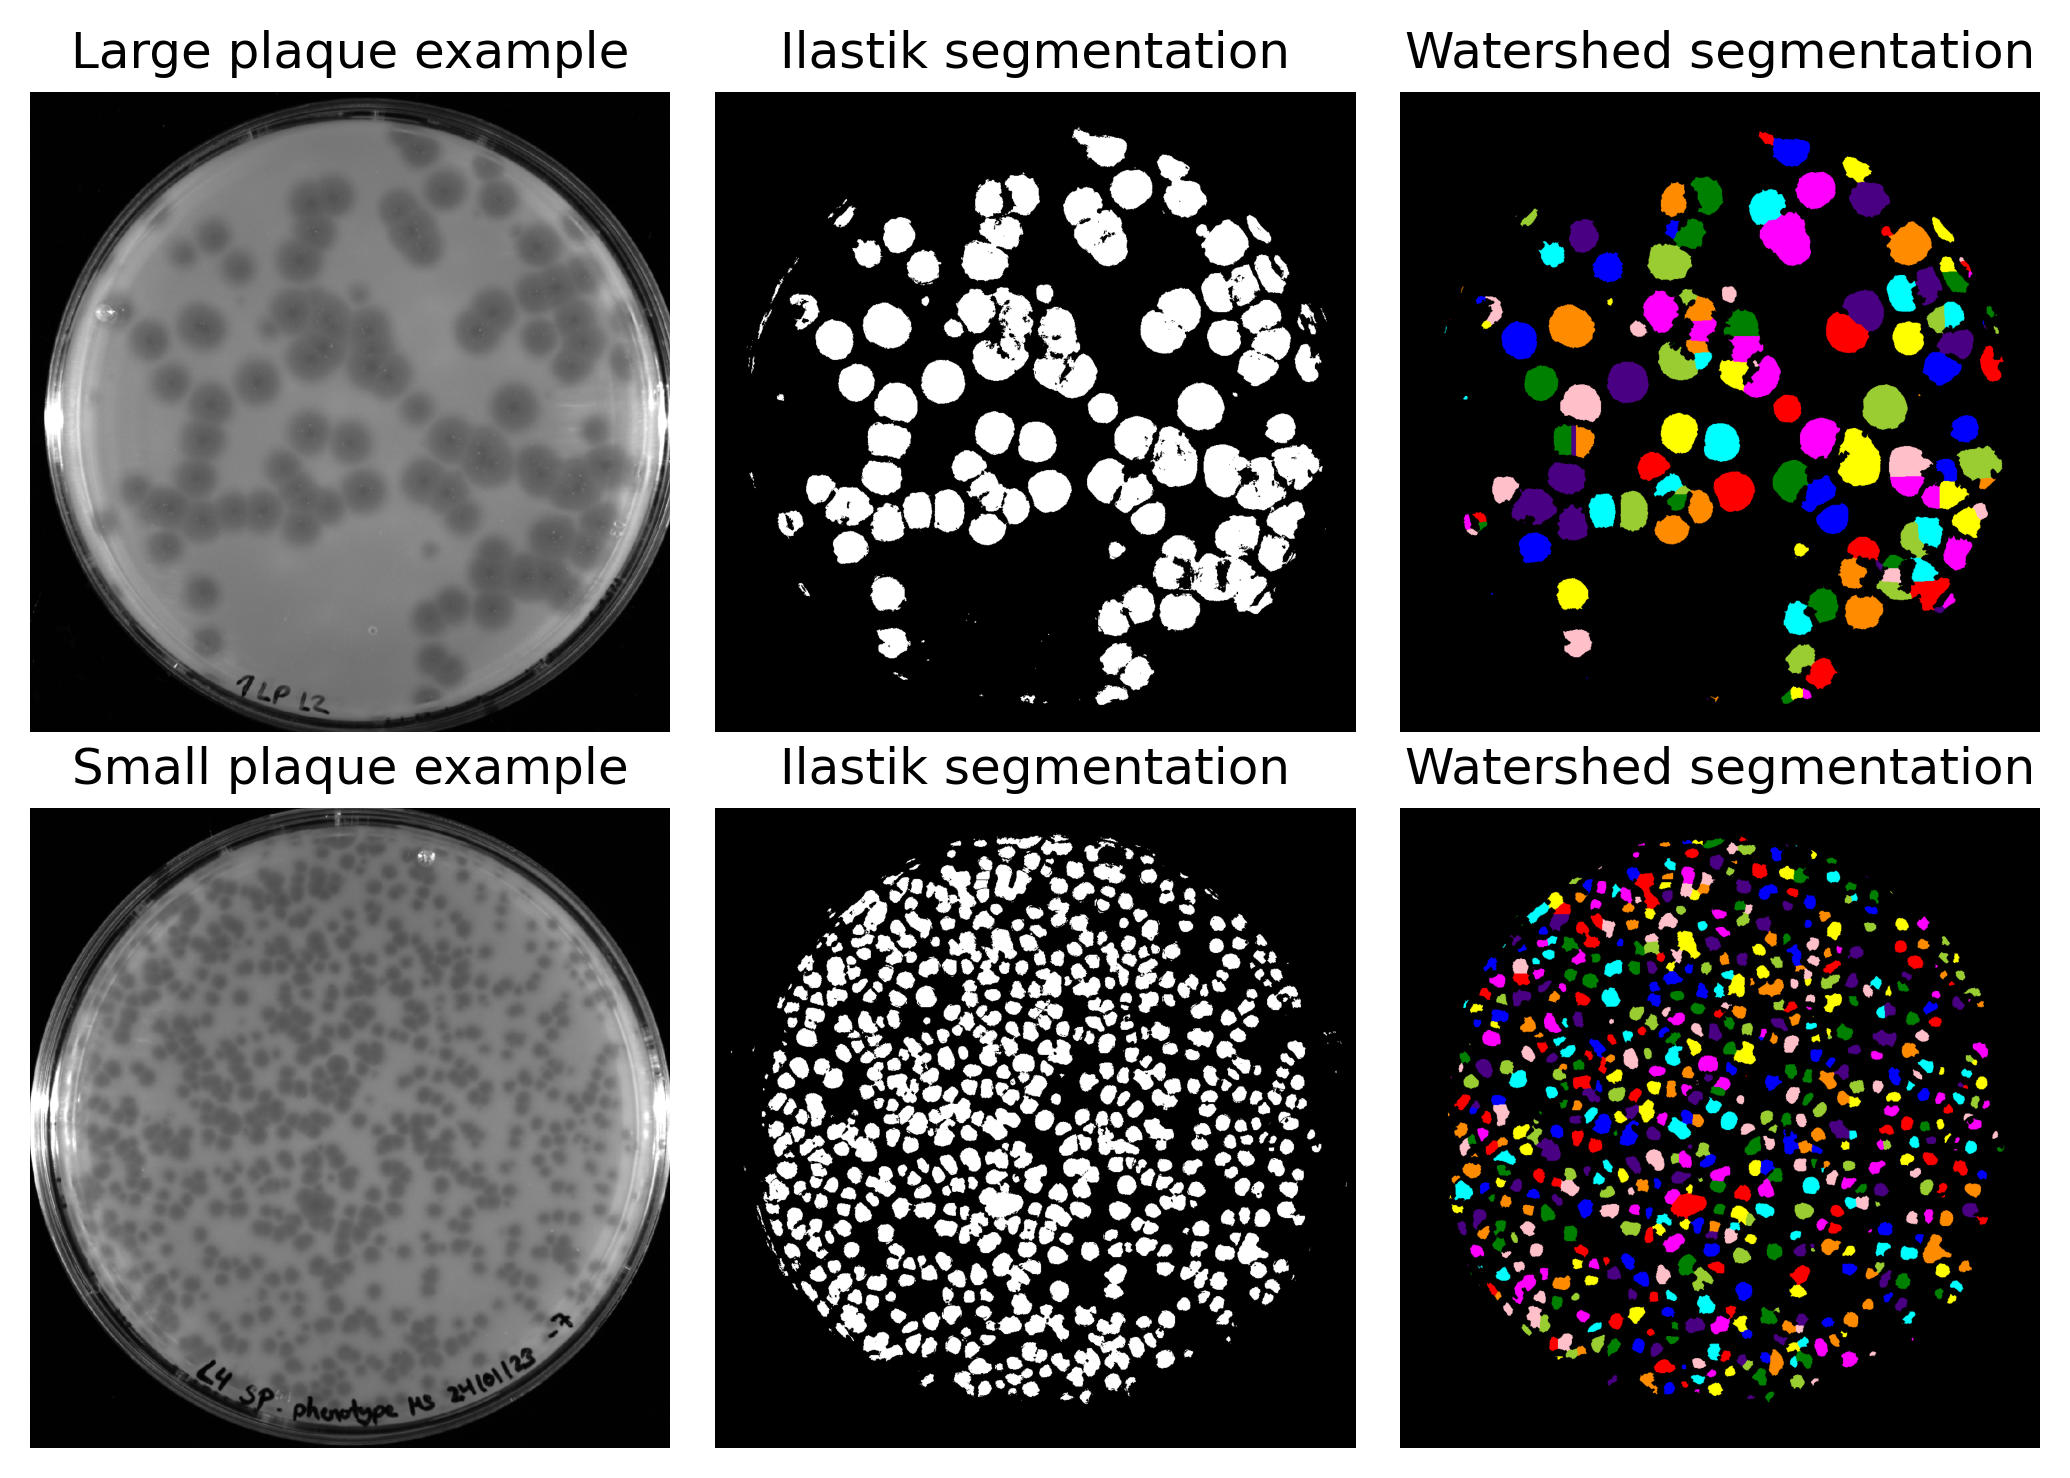

In [23]:
### For the selected images, watershed segment them and show results with the previously defined function

fig,ax = plt.subplots(dpi=300,ncols=3,nrows=2,figsize=(7,5))

ax[0,0].imshow(lp, cmap='Greys_r')
ax[0,0].axis('off')
ax[0,0].set_xlim(600,1700)
ax[0,0].set_ylim(1550,450)
ax[0,0].set_title(f'Large plaque example')

ax[0,1].imshow(lp_seg == 2, cmap='Greys_r')
ax[0,1].axis('off')
ax[0,1].set_xlim(600,1700)
ax[0,1].set_ylim(1550,450)
ax[0,1].set_title(f'Ilastik segmentation')

ax[0,2].imshow(label2rgb(lp_seg_watershed))
ax[0,2].axis('off')
ax[0,2].set_xlim(600,1700)
ax[0,2].set_ylim(1550,450)
ax[0,2].set_title(f'Watershed segmentation')

ax[1,0].imshow(sp, cmap='Greys_r')
ax[1,0].axis('off')
ax[1,0].set_xlim(700,1800)
ax[1,0].set_ylim(1650,550)
ax[1,0].set_title(f'Small plaque example')

ax[1,1].imshow(sp_seg, cmap='Greys_r')
ax[1,1].axis('off')
ax[1,1].set_xlim(700,1800)
ax[1,1].set_ylim(1650,550)
ax[1,1].set_title(f'Ilastik segmentation')

ax[1,2].imshow(label2rgb(sp_seg_watershed))
ax[1,2].axis('off')
ax[1,2].set_xlim(700,1800)
ax[1,2].set_ylim(1650,550)
ax[1,2].set_title(f'Watershed segmentation')

fig.tight_layout()
fig.savefig('/Users/reyesmatte/Desktop/Reuter_2025/Watershed_example/Watershed.png')
